In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/chandniagarwal/Gan_Classifier.git

Cloning into 'Gan_Classifier'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 48 (delta 13), reused 46 (delta 11), pack-reused 0
Receiving objects: 100% (48/48), 835.10 KiB | 21.98 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [3]:
!mkdir training
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/recon /content/training/recon
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/celebagt /content/training/ground
!cp -r /content/drive/MyDrive/researchwork_15.9.203/testing /content/testing

In [4]:
import sys
sys.path.append('/content/Gan_Classifier/src')
import glob
import os
import numpy as np
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras import optimizers


from keras.models import Sequential
from keras.layers import Input, Dense, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import time
import random
import seaborn as sns
from DatasetCreation import DatasetCreation
from Model import Model
from ElmModel import elm
from numba import cuda

In [5]:
tf.random.set_seed(
    42
)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
list_images=[]
labels=[]

In [6]:
# Testing Data Location
test_gt = "/content/drive/MyDrive/researchwork_15.9.203/testing/gt"
test_gen = "/content/drive/MyDrive/researchwork_15.9.203/testing/gen"
test_ec = "/content/drive/MyDrive/researchwork_15.9.203/testing/ec"
test_vqvae = "/content/drive/MyDrive/researchwork_15.9.203/testing/vqvae"
test_mask = "/content/drive/MyDrive/imageclassificationmodel/dataset/mask2000"
test_unmask = "/content/drive/MyDrive/imageclassificationmodel/dataset/gt2000"

In [7]:
# test_gt = '/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/e3'
# test_vqvae='/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/g3'

In [8]:
# Training Data Location
train_gt='/content/training/ground'
train_recon='/content/training/recon'

In [9]:
# training Data
image_loc_ground = glob.glob(train_gt+"/*.jpg")
labels = len(image_loc_ground) * ["ground"]
image_loc_recon = glob.glob(train_recon+"/*.jpg")

labels += len(image_loc_recon) * ["recon"]
image_loc = image_loc_ground + image_loc_recon

training_dataset = DatasetCreation(image_loc, labels, "binary")
# for 152 layer
training_dataset_152_layer = DatasetCreation(
    image_loc, labels, "binary", tf.keras.applications.resnet50.preprocess_input
)
print(training_dataset.images.shape)
print(training_dataset.labels.shape)

_________Loading Images__________


100%|██████████| 7178/7178 [00:24<00:00, 293.35it/s]


_________Loading Images__________


100%|██████████| 7178/7178 [00:14<00:00, 488.55it/s]


(7178, 224, 224, 3)
(7178,)


## load model

In [10]:
def load_model(model_function, trainable:bool):
  start = time.time()
  # load resnet model
  base_model = model_function(
      input_shape=(224,224,3),
      include_top=False,
      weights='imagenet'
  )

  for layer in base_model.layers:
      layer.trainable = trainable

  # Create your binary classification layers on top of the base model
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
  x = tf.keras.layers.Dense(1000, activation='relu')(x) # intermediate hidden layer
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary classification output layer

  # Combine the base model and your custom layers into a new model
  model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

  print('Running time: %.4f seconds' % (time.time()-start))
  return model

In [11]:
model_resnet_152_full = load_model(tf.keras.applications.ResNet152, True)
model_resnet_101_full = load_model(tf.keras.applications.ResNet101, True)
model_resnet_50_full = load_model(tf.keras.applications.ResNet50, True)

model_resnet_152_freeze = load_model(tf.keras.applications.ResNet152, False)
model_resnet_101_freeze = load_model(tf.keras.applications.ResNet101, False)
model_resnet_50_freeze = load_model(tf.keras.applications.ResNet50, False)

234698864/234698864 [==============================] - 14s 0us/step
Running time: 21.5232 seconds
171446536/171446536 [==============================] - 9s 0us/step
Running time: 12.6324 seconds
94765736/94765736 [==============================] - 5s 0us/step
Running time: 7.1372 seconds
Running time: 4.8212 seconds
Running time: 3.1626 seconds
Running time: 1.6291 seconds


In [12]:
model_softmax = {
    "152_full": model_resnet_152_full,
    "101_full": model_resnet_101_full,
    "50_full": model_resnet_50_full,
    "152_freeze": model_resnet_152_freeze,
    "101_freeze": model_resnet_101_freeze,
    "50_freeze": model_resnet_50_freeze,
}
model_data = {
    "152_full": training_dataset_152_layer,
    "101_full": training_dataset,
    "50_full": training_dataset,
    "152_freeze": training_dataset_152_layer,
    "101_freeze": training_dataset,
    "50_freeze": training_dataset,
}

## Resnet Training

In [13]:
for key in model_softmax.keys():
  print("_"*10, key, "_"*50)
  model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint_sigmoid/{key}', "binary_crossentropy")
  model_softmax[key].train(model_data[key].images, model_data[key].labels, batch_size=64, epoch=10)
  tf.keras.backend.clear_session()

__________ 152_full __________________________________________________
Epoch 1/10
101/101 [==============================] - 142s 286ms/step - loss: 0.2803 - accuracy: 0.9036 - val_loss: 44464.3398 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10
101/101 [==============================] - 23s 225ms/step - loss: 0.0771 - accuracy: 0.9717 - val_loss: 2.2127 - val_accuracy: 0.4554 - lr: 0.0010
Epoch 3/10
101/101 [==============================] - 21s 210ms/step - loss: 0.0608 - accuracy: 0.9786 - val_loss: 4.8933 - val_accuracy: 0.5487 - lr: 0.0010
Epoch 4/10
101/101 [==============================] - 23s 224ms/step - loss: 0.0386 - accuracy: 0.9858 - val_loss: 0.5291 - val_accuracy: 0.8983 - lr: 0.0010
Epoch 5/10
101/101 [==============================] - 23s 223ms/step - loss: 0.0393 - accuracy: 0.9870 - val_loss: 0.1838 - val_accuracy: 0.9457 - lr: 0.0010
Epoch 6/10
101/101 [==============================] - 21s 211ms/step - loss: 0.0404 - accuracy: 0.9850 - val_loss: 2.2680 - val_ac

## Elm Training

In [14]:
for key in model_softmax.keys():
  for layer in model_softmax[key].model.layers:
      layer.trainable = False
  model_softmax[key].remove_layer(2)

In [15]:
def batch_predict(model, images, batch=32):
  array1 = []
  for idx in range(0, len(images), batch):
    array2 = model.predict(images[idx: min(len(images), idx+batch)], verbose=0)
    if len(array1)>0:
      array1 = np.concatenate((array1, array2), axis=0)
    else:
      array1 = array2
  return array1

In [16]:
model_elm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 64)
  Ytrain = model_data[key].labels

  model_elm[key] = elm(hidden_units=16, activation_function='relu', random_type='normal', x=Xtrain, y=Ytrain, C=0.1, elm_type='clf')
  beta, train_accuracy, running_time = model_elm[key].fit('solution2')
  print("classifier train accuracy:", train_accuracy)
  print('classifier running time:', running_time)

__________ 152_full __________
classifier train accuracy: 0.9990247979938701
classifier running time: 0.03793692588806152
__________ 101_full __________
classifier train accuracy: 0.9990247979938701
classifier running time: 0.023236989974975586
__________ 50_full __________
classifier train accuracy: 0.999442741710783
classifier running time: 0.023281574249267578
__________ 152_freeze __________
classifier train accuracy: 0.8140150459738089
classifier running time: 0.022054433822631836
__________ 101_freeze __________
classifier train accuracy: 0.558790749512399
classifier running time: 0.024419784545898438
__________ 50_freeze __________
classifier train accuracy: 0.6036500417943717
classifier running time: 0.021954774856567383


## Svm Training

In [17]:
model_svm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  #with tf.device('/CPU:0'):
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 64)
  Ytrain = model_data[key].labels
  model_svm[key] = make_pipeline(SVC())
  model_svm[key].fit(Xtrain, Ytrain)
  print("Classifier train accuracy:", model_svm[key].score(Xtrain, Ytrain))

__________ 152_full __________
Classifier train accuracy: 0.9993034271384786
__________ 101_full __________
Classifier train accuracy: 0.9988854834215659
__________ 50_full __________
Classifier train accuracy: 0.9993034271384786
__________ 152_freeze __________
Classifier train accuracy: 0.9133463360267484
__________ 101_freeze __________
Classifier train accuracy: 0.609083310114238
__________ 50_freeze __________
Classifier train accuracy: 0.641404290888827


In [18]:
#dump training data
training_dataset = None
training_dataset_152_layer = None
model_data = None

## Load Test Data

In [19]:
# test Data
image_loc_ground = glob.glob(test_gt+"/*.jpg")
label_ground = len(image_loc_ground) * ["ground"]

image_loc_gen = glob.glob(test_gen+"/*.jpg")
label_gen = len(image_loc_gen) * ["recon"]

image_loc_ec = glob.glob(test_ec+"/*.jpg")
label_ec = len(image_loc_ec) * ["recon"]

image_loc_vqvae = glob.glob(test_vqvae+"/*.jpg")
label_vqvae = len(image_loc_vqvae) * ["recon"]

test_dataset = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary"
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary"
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary"
        ),
}

test_dataset_152_layer = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
}
model_data = {
    "152_full": test_dataset_152_layer,
    "101_full": test_dataset,
    "50_full": test_dataset,
    "152_freeze": test_dataset_152_layer,
    "101_freeze": test_dataset,
    "50_freeze": test_dataset,
}

_________Loading Images__________


100%|██████████| 1000/1000 [00:05<00:00, 198.88it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 212.92it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 208.25it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 275.60it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 290.78it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 286.45it/s]


## Testing Resnet



 __________________________________________________ 152_full __________________________________________________

__________gen__________
Accuracy 0.992
Precision: 0.988000
Recall: 0.995968
F1 score: 0.991968
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       500
           1       1.00      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



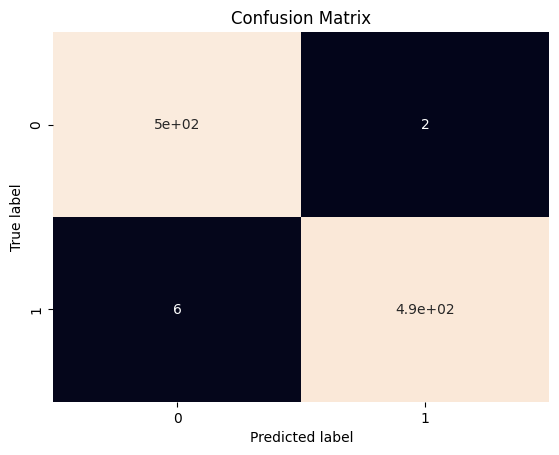

__________ec__________
Accuracy 0.997
Precision: 0.998000
Recall: 0.996008
F1 score: 0.997003
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



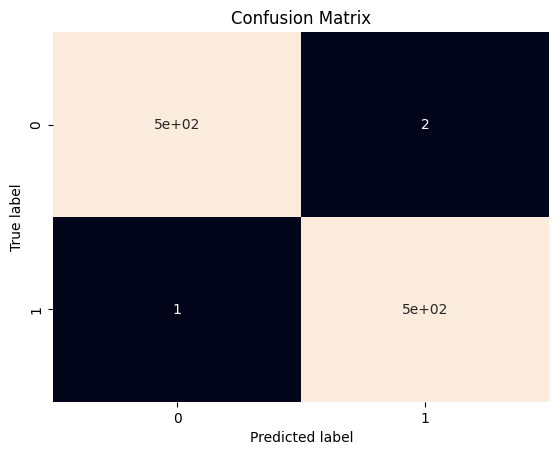

__________vqvae__________
Accuracy 0.995
Precision: 0.994000
Recall: 0.995992
F1 score: 0.994995
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       500
           1       1.00      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000



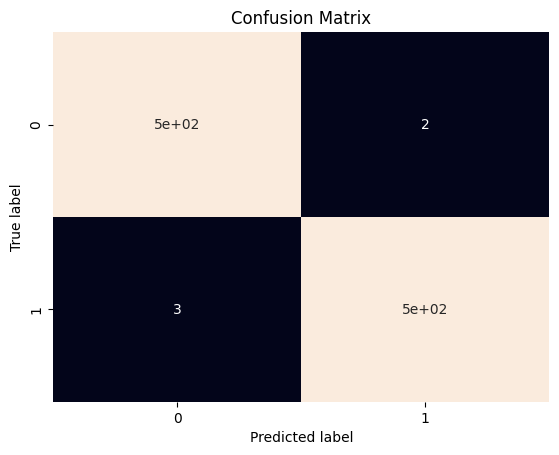



 __________________________________________________ 101_full __________________________________________________

__________gen__________
Accuracy 0.984
Precision: 0.984000
Recall: 0.984000
F1 score: 0.984000
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       500
           1       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



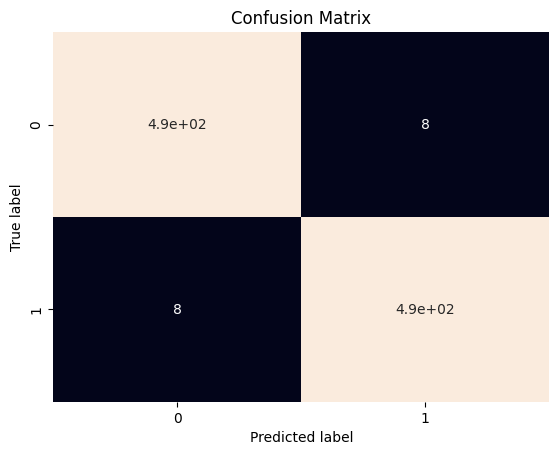

__________ec__________
Accuracy 0.992
Precision: 1.000000
Recall: 0.984252
F1 score: 0.992063
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       500
           1       0.98      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



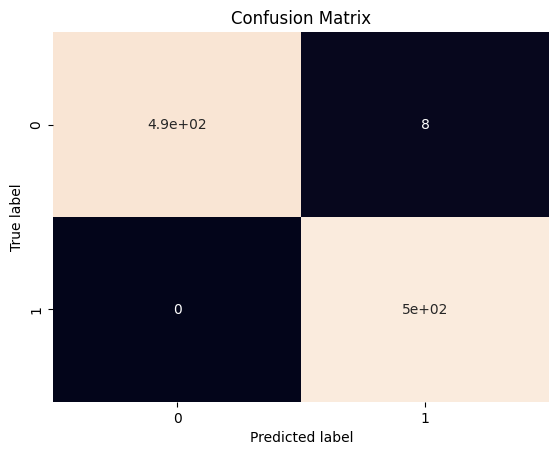

__________vqvae__________
Accuracy 0.992
Precision: 1.000000
Recall: 0.984252
F1 score: 0.992063
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       500
           1       0.98      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



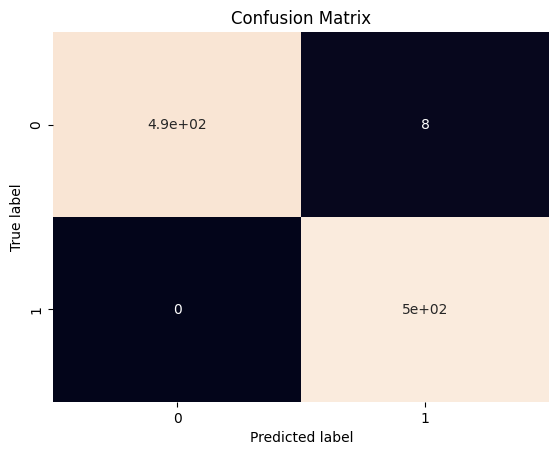



 __________________________________________________ 50_full __________________________________________________

__________gen__________
Accuracy 0.993
Precision: 0.994000
Recall: 0.992016
F1 score: 0.993007
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       0.99      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



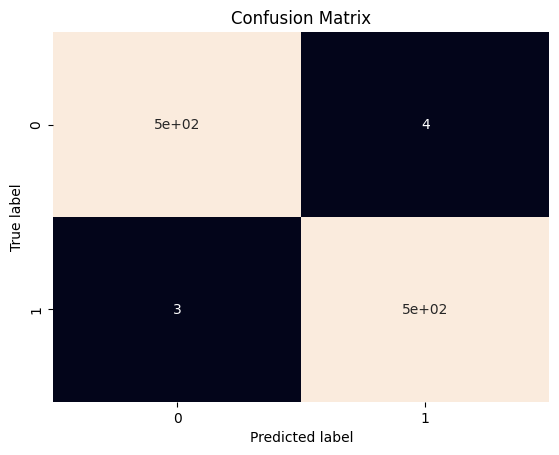

__________ec__________
Accuracy 0.996
Precision: 1.000000
Recall: 0.992063
F1 score: 0.996016
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       500
           1       0.99      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



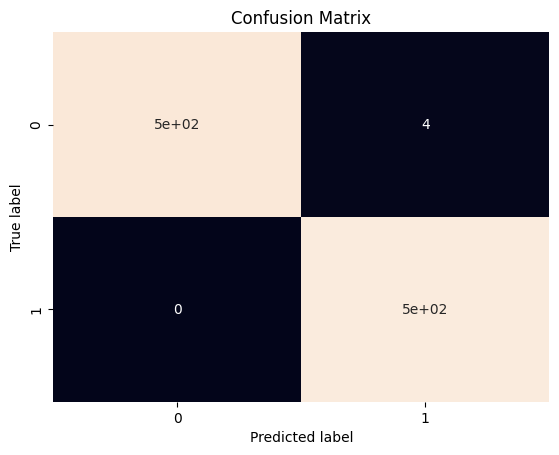

__________vqvae__________
Accuracy 0.995
Precision: 0.998000
Recall: 0.992048
F1 score: 0.995015
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      1.00       500

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000



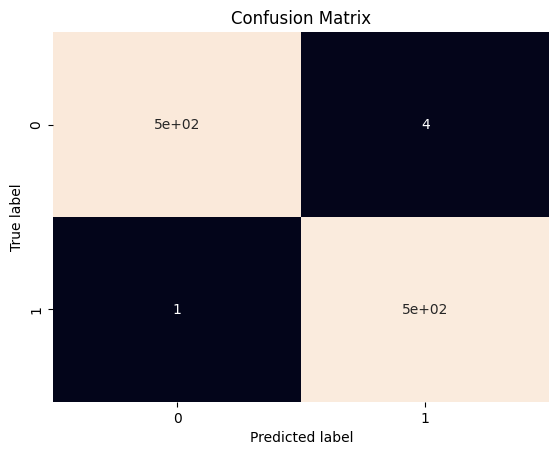



 __________________________________________________ 152_freeze __________________________________________________

__________gen__________
Accuracy 0.756
Precision: 0.764000
Recall: 0.751969
F1 score: 0.757937
              precision    recall  f1-score   support

           0       0.76      0.75      0.75       500
           1       0.75      0.76      0.76       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



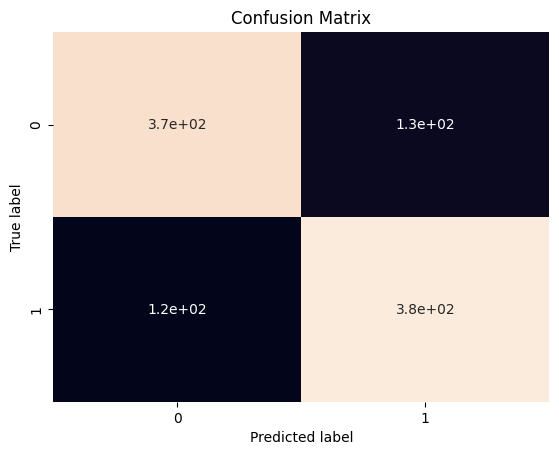

__________ec__________
Accuracy 0.867
Precision: 0.986000
Recall: 0.796446
F1 score: 0.881144
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       500
           1       0.80      0.99      0.88       500

    accuracy                           0.87      1000
   macro avg       0.89      0.87      0.87      1000
weighted avg       0.89      0.87      0.87      1000



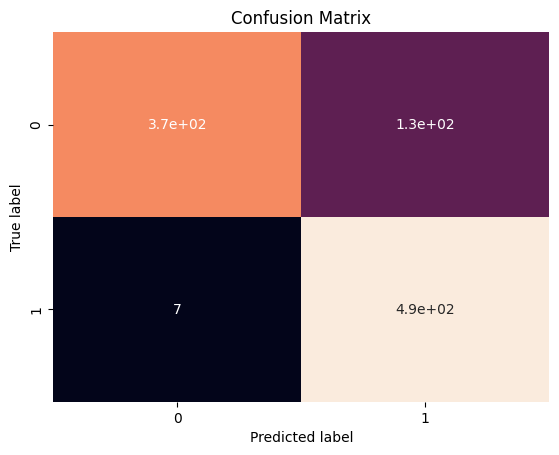

__________vqvae__________
Accuracy 0.847
Precision: 0.946000
Recall: 0.789649
F1 score: 0.860783
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       500
           1       0.79      0.95      0.86       500

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.86      0.85      0.85      1000



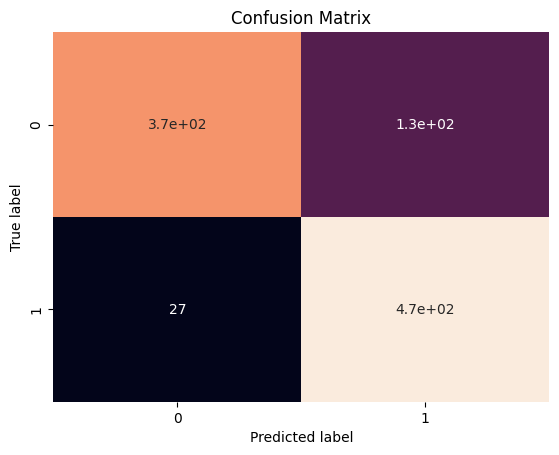



 __________________________________________________ 101_freeze __________________________________________________

__________gen__________
Accuracy 0.549
Precision: 0.500000
Recall: 0.554324
F1 score: 0.525762
              precision    recall  f1-score   support

           0       0.54      0.60      0.57       500
           1       0.55      0.50      0.53       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000



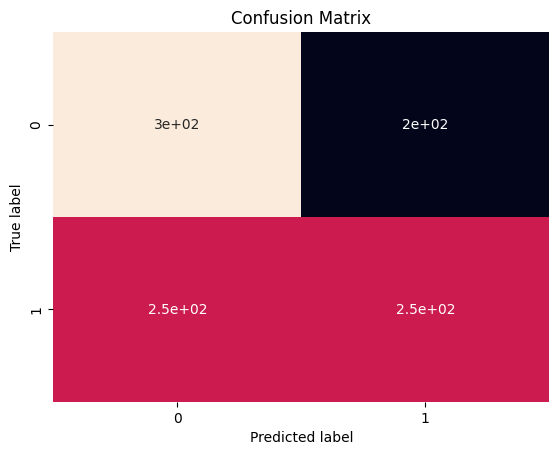

__________ec__________
Accuracy 0.638
Precision: 0.678000
Recall: 0.627778
F1 score: 0.651923
              precision    recall  f1-score   support

           0       0.65      0.60      0.62       500
           1       0.63      0.68      0.65       500

    accuracy                           0.64      1000
   macro avg       0.64      0.64      0.64      1000
weighted avg       0.64      0.64      0.64      1000



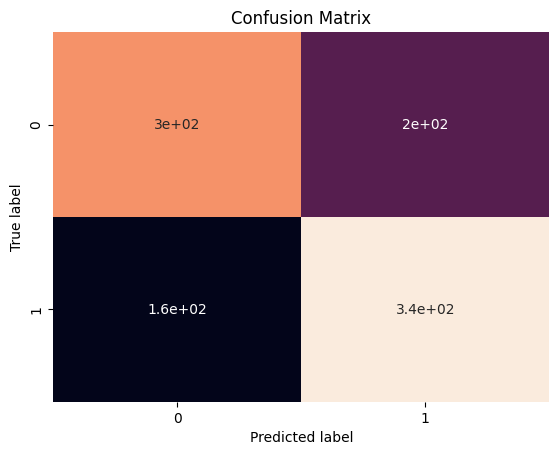

__________vqvae__________
Accuracy 0.502
Precision: 0.406000
Recall: 0.502475
F1 score: 0.449115
              precision    recall  f1-score   support

           0       0.50      0.60      0.55       500
           1       0.50      0.41      0.45       500

    accuracy                           0.50      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.50      0.50      0.50      1000



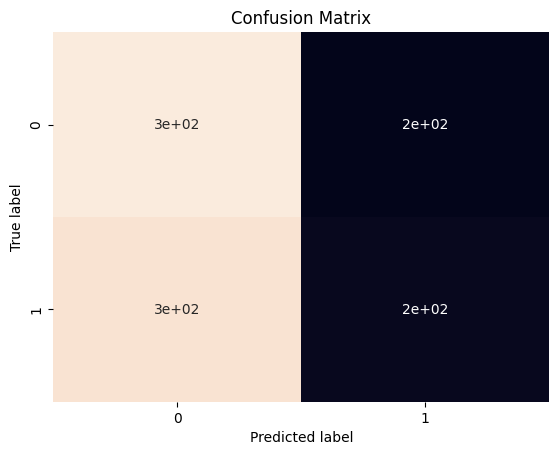



 __________________________________________________ 50_freeze __________________________________________________

__________gen__________
Accuracy 0.571
Precision: 0.690000
Recall: 0.557351
F1 score: 0.616622
              precision    recall  f1-score   support

           0       0.59      0.45      0.51       500
           1       0.56      0.69      0.62       500

    accuracy                           0.57      1000
   macro avg       0.58      0.57      0.56      1000
weighted avg       0.58      0.57      0.56      1000



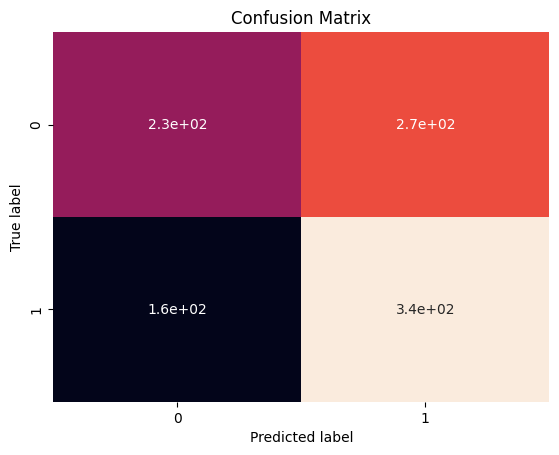

__________ec__________
Accuracy 0.674
Precision: 0.896000
Recall: 0.620499
F1 score: 0.733224
              precision    recall  f1-score   support

           0       0.81      0.45      0.58       500
           1       0.62      0.90      0.73       500

    accuracy                           0.67      1000
   macro avg       0.72      0.67      0.66      1000
weighted avg       0.72      0.67      0.66      1000



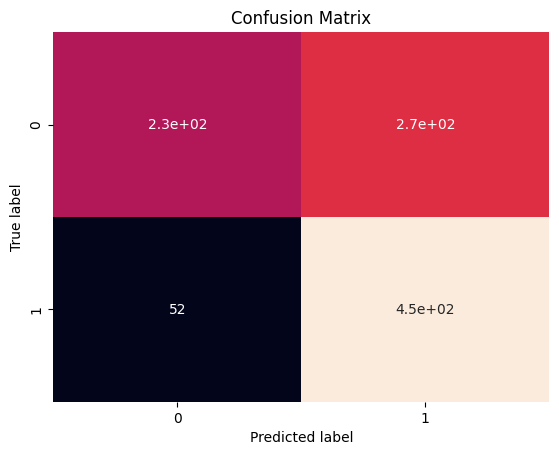

__________vqvae__________
Accuracy 0.558
Precision: 0.664000
Recall: 0.547855
F1 score: 0.600362
              precision    recall  f1-score   support

           0       0.57      0.45      0.51       500
           1       0.55      0.66      0.60       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.55      1000
weighted avg       0.56      0.56      0.55      1000



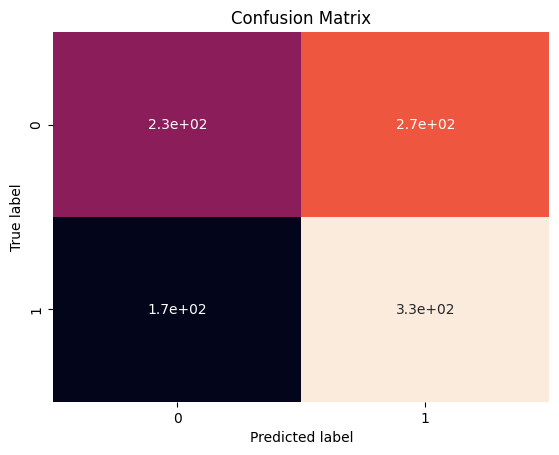

In [22]:
for model_name in model_softmax.keys():
  print("\n\n","_"*50, model_name, "_"*50, end = "\n\n")

  for key in model_data[model_name].keys():
    y_result = batch_predict(model_softmax[model_name].model, model_data[model_name][key].images, 64)
    y_result = y_result>0.5

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    print(classification_report(labels, y_result))

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

## Testing ELM



 __________________________________________________ 152_full __________________________________________________

__________gen__________
Accuracy 0.99
Precision: 0.984000
Recall: 0.995951
F1 score: 0.989940
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       500
           1       1.00      0.98      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



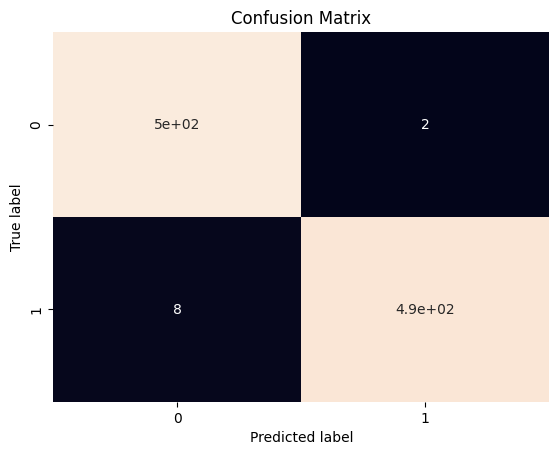

__________ec__________
Accuracy 0.997
Precision: 0.998000
Recall: 0.996008
F1 score: 0.997003
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



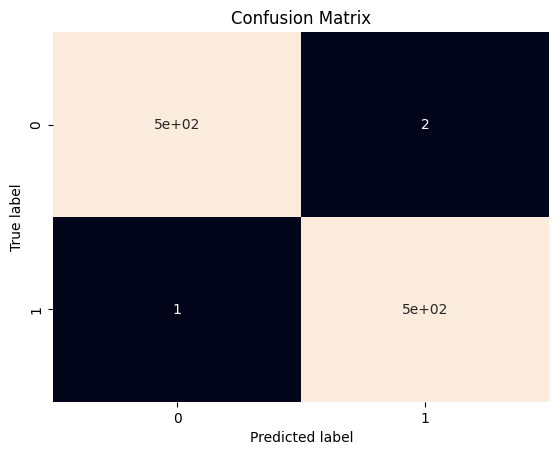

__________vqvae__________
Accuracy 0.994
Precision: 0.992000
Recall: 0.995984
F1 score: 0.993988
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       500
           1       1.00      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



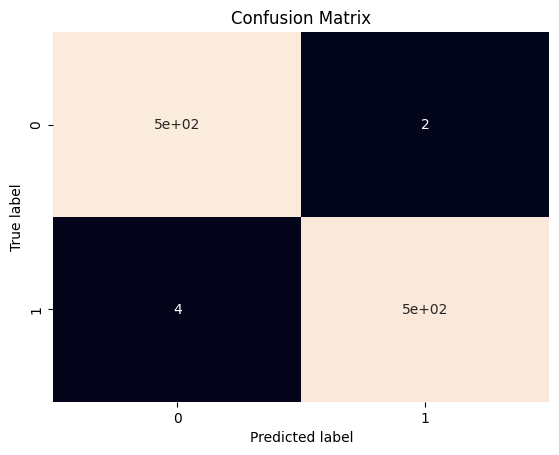



 __________________________________________________ 101_full __________________________________________________

__________gen__________
Accuracy 0.984
Precision: 0.984000
Recall: 0.984000
F1 score: 0.984000
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       500
           1       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



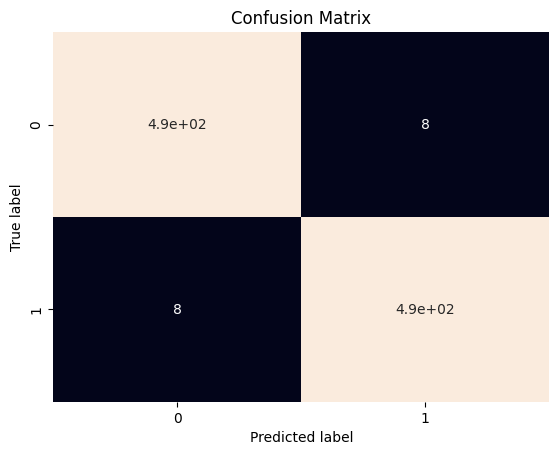

__________ec__________
Accuracy 0.992
Precision: 1.000000
Recall: 0.984252
F1 score: 0.992063
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       500
           1       0.98      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



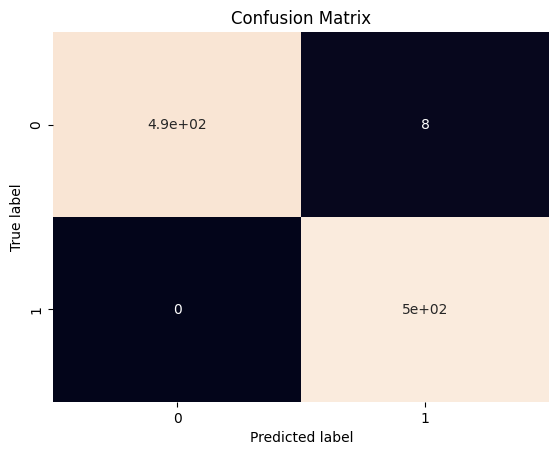

__________vqvae__________
Accuracy 0.992
Precision: 1.000000
Recall: 0.984252
F1 score: 0.992063
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       500
           1       0.98      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



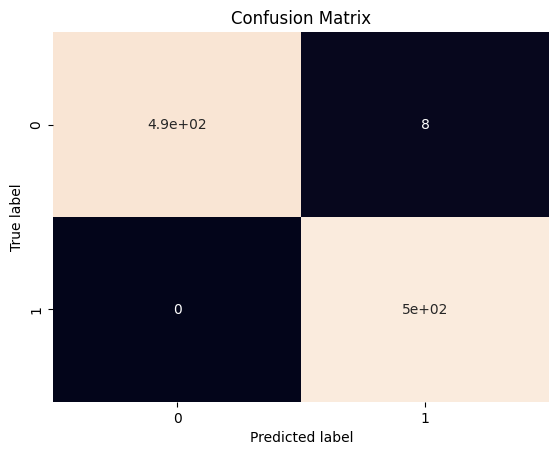



 __________________________________________________ 50_full __________________________________________________

__________gen__________
Accuracy 0.992
Precision: 0.996000
Recall: 0.988095
F1 score: 0.992032
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



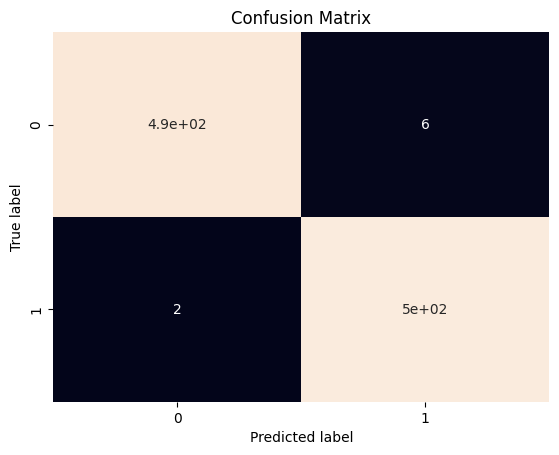

__________ec__________
Accuracy 0.994
Precision: 1.000000
Recall: 0.988142
F1 score: 0.994036
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



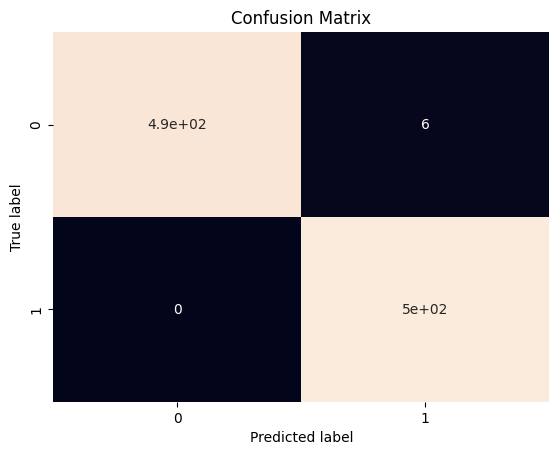

__________vqvae__________
Accuracy 0.993
Precision: 0.998000
Recall: 0.988119
F1 score: 0.993035
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



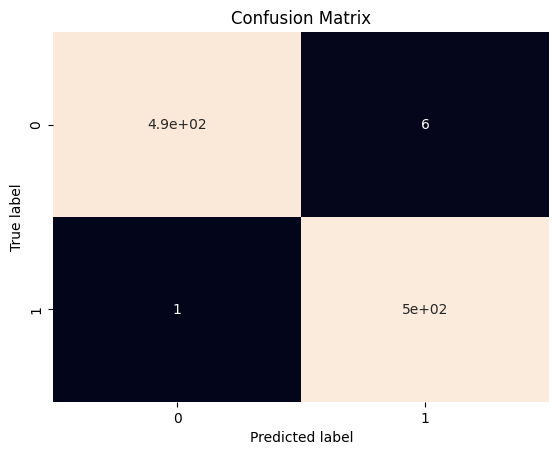



 __________________________________________________ 152_freeze __________________________________________________

__________gen__________
Accuracy 0.699
Precision: 0.588000
Recall: 0.755784
F1 score: 0.661417
              precision    recall  f1-score   support

           0       0.66      0.81      0.73       500
           1       0.76      0.59      0.66       500

    accuracy                           0.70      1000
   macro avg       0.71      0.70      0.70      1000
weighted avg       0.71      0.70      0.70      1000



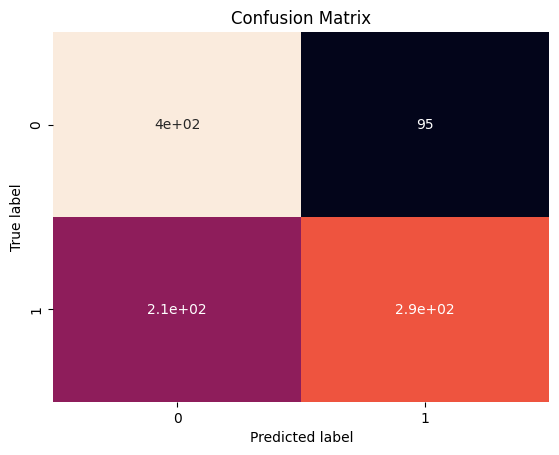

__________ec__________
Accuracy 0.869
Precision: 0.928000
Recall: 0.830054
F1 score: 0.876298
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       500
           1       0.83      0.93      0.88       500

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



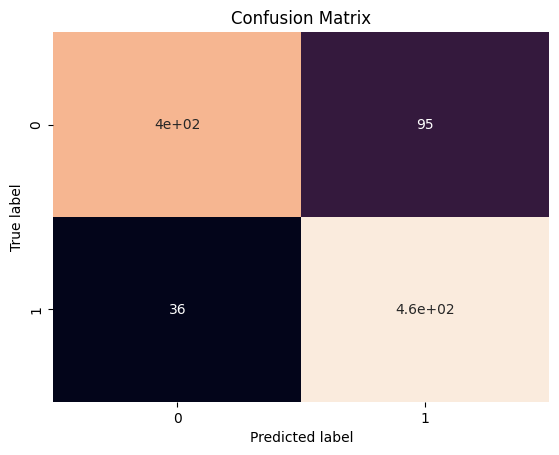

__________vqvae__________
Accuracy 0.841
Precision: 0.872000
Recall: 0.821092
F1 score: 0.845781
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       500
           1       0.82      0.87      0.85       500

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



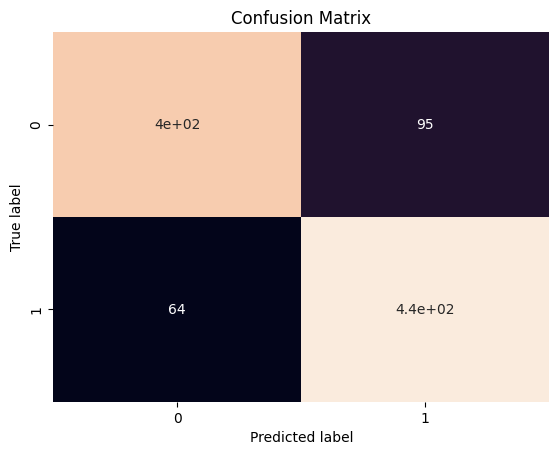



 __________________________________________________ 101_freeze __________________________________________________

__________gen__________
Accuracy 0.55
Precision: 0.578000
Recall: 0.547348
F1 score: 0.562257
              precision    recall  f1-score   support

           0       0.55      0.52      0.54       500
           1       0.55      0.58      0.56       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000



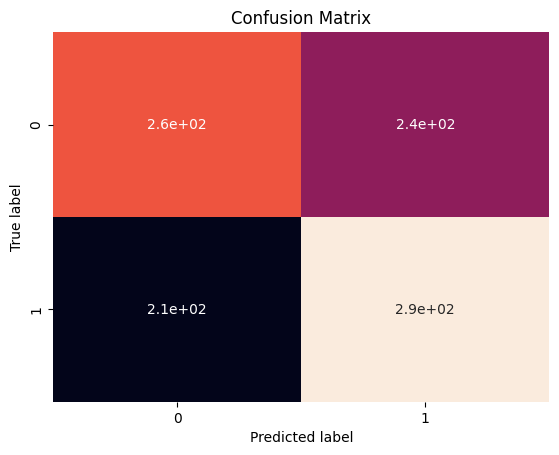

__________ec__________
Accuracy 0.603
Precision: 0.684000
Recall: 0.588640
F1 score: 0.632747
              precision    recall  f1-score   support

           0       0.62      0.52      0.57       500
           1       0.59      0.68      0.63       500

    accuracy                           0.60      1000
   macro avg       0.61      0.60      0.60      1000
weighted avg       0.61      0.60      0.60      1000



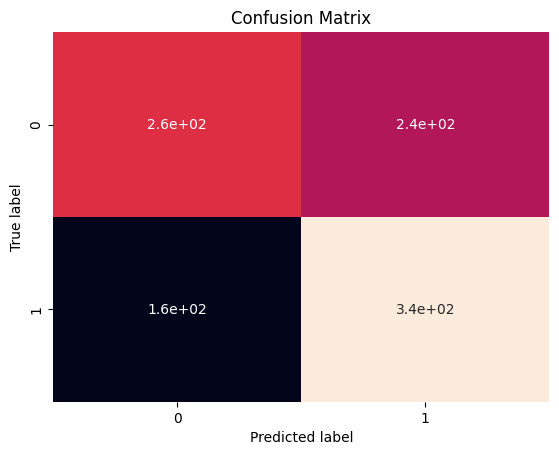

__________vqvae__________
Accuracy 0.496
Precision: 0.470000
Recall: 0.495781
F1 score: 0.482546
              precision    recall  f1-score   support

           0       0.50      0.52      0.51       500
           1       0.50      0.47      0.48       500

    accuracy                           0.50      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.50      0.50      0.50      1000



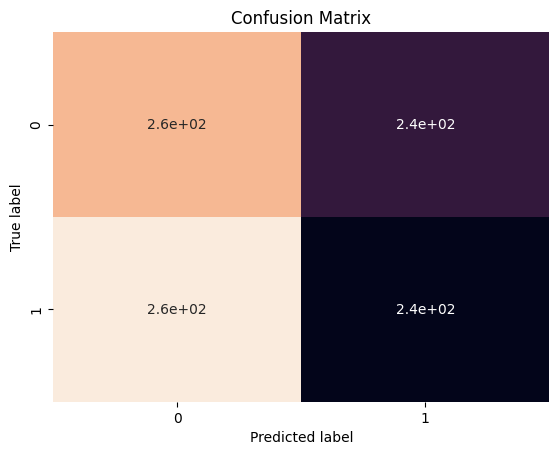



 __________________________________________________ 50_freeze __________________________________________________

__________gen__________
Accuracy 0.567
Precision: 0.548000
Recall: 0.569647
F1 score: 0.558614
              precision    recall  f1-score   support

           0       0.56      0.59      0.58       500
           1       0.57      0.55      0.56       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000



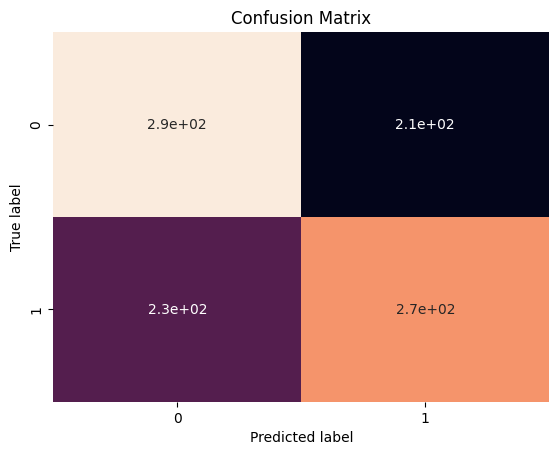

__________ec__________
Accuracy 0.704
Precision: 0.822000
Recall: 0.665049
F1 score: 0.735242
              precision    recall  f1-score   support

           0       0.77      0.59      0.66       500
           1       0.67      0.82      0.74       500

    accuracy                           0.70      1000
   macro avg       0.72      0.70      0.70      1000
weighted avg       0.72      0.70      0.70      1000



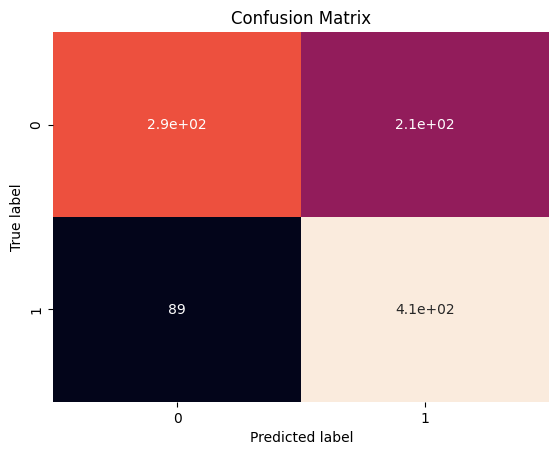

__________vqvae__________
Accuracy 0.56
Precision: 0.534000
Recall: 0.563291
F1 score: 0.548255
              precision    recall  f1-score   support

           0       0.56      0.59      0.57       500
           1       0.56      0.53      0.55       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.56      1000
weighted avg       0.56      0.56      0.56      1000



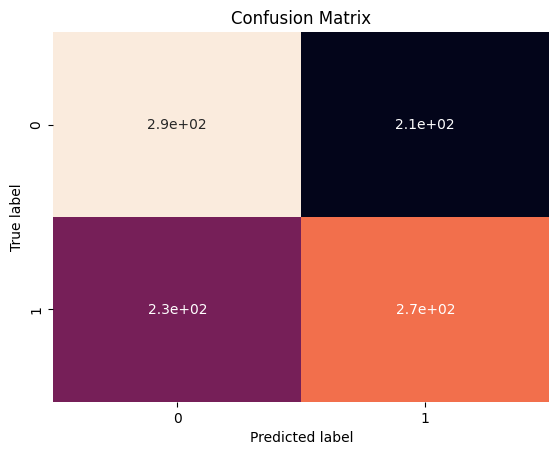

In [23]:
for model_name in model_softmax.keys():
  print("\n\n","_"*50, model_name, "_"*50, end = "\n\n")

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 64)
    y_result = model_elm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    print(classification_report(labels, y_result))

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

## Testing SVM



 __________________________________________________ 152_full __________________________________________________

__________gen__________
Accuracy 0.989
Precision: 0.990000
Recall: 0.988024
F1 score: 0.989011
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       0.99      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



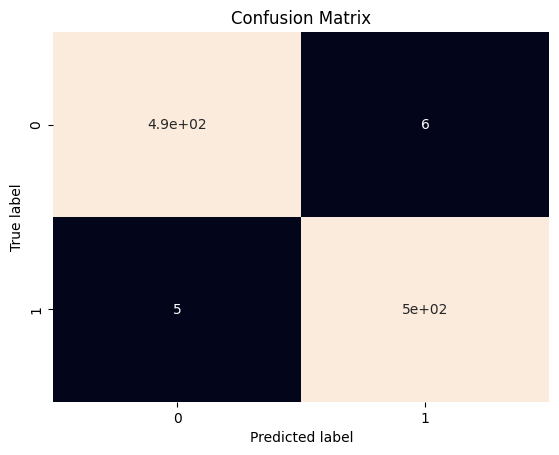

__________ec__________
Accuracy 0.994
Precision: 1.000000
Recall: 0.988142
F1 score: 0.994036
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



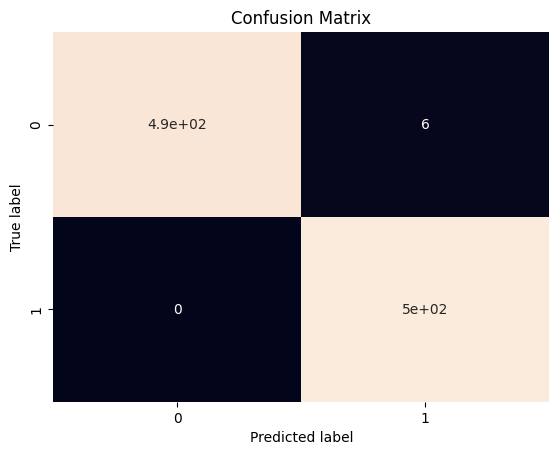

__________vqvae__________
Accuracy 0.993
Precision: 0.998000
Recall: 0.988119
F1 score: 0.993035
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



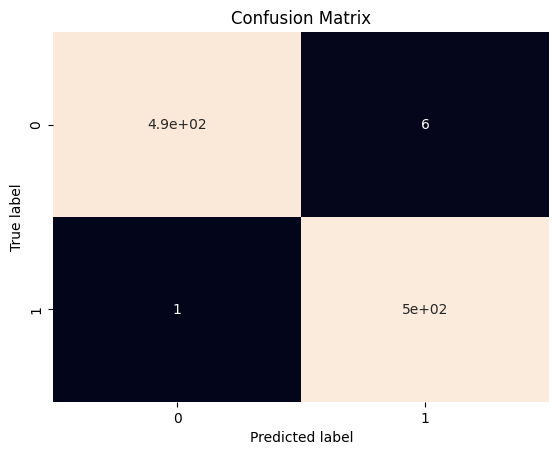



 __________________________________________________ 101_full __________________________________________________

__________gen__________
Accuracy 0.983
Precision: 0.990000
Recall: 0.976331
F1 score: 0.983118
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       500
           1       0.98      0.99      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



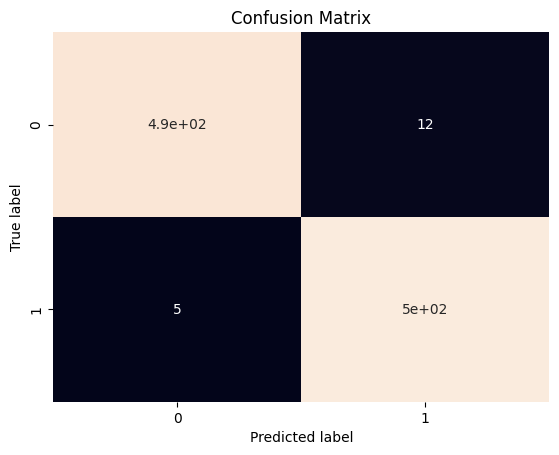

__________ec__________
Accuracy 0.988
Precision: 1.000000
Recall: 0.976562
F1 score: 0.988142
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       500
           1       0.98      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



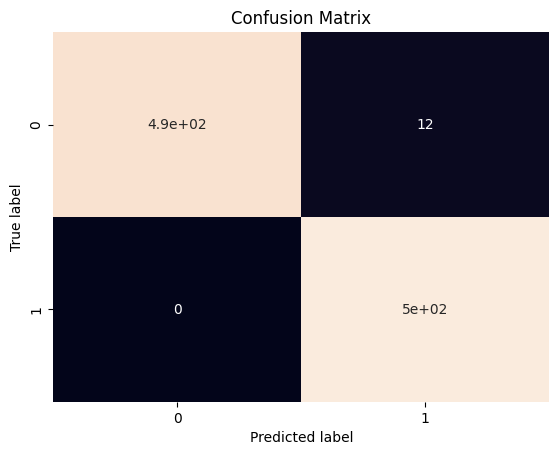

__________vqvae__________
Accuracy 0.988
Precision: 1.000000
Recall: 0.976562
F1 score: 0.988142
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       500
           1       0.98      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



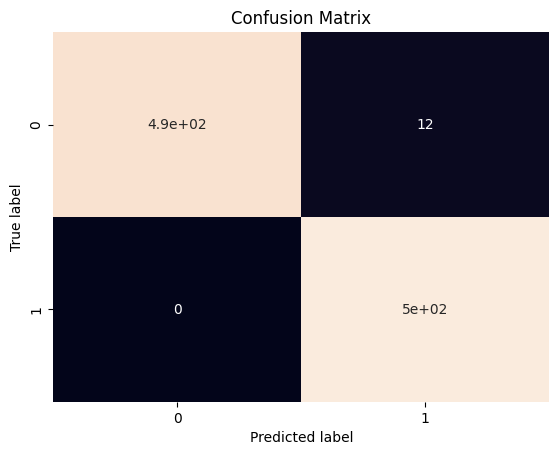



 __________________________________________________ 50_full __________________________________________________

__________gen__________
Accuracy 0.991
Precision: 0.996000
Recall: 0.986139
F1 score: 0.991045
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



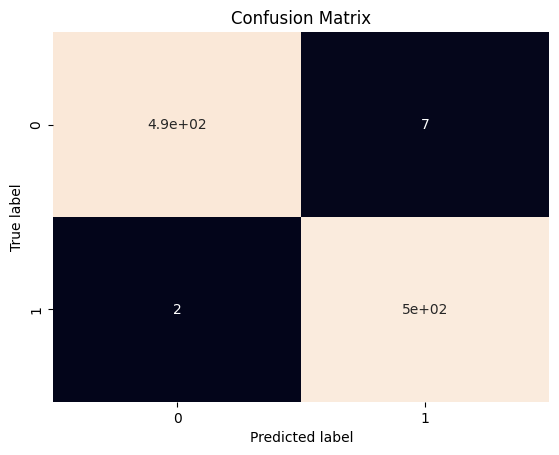

__________ec__________
Accuracy 0.993
Precision: 1.000000
Recall: 0.986193
F1 score: 0.993049
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



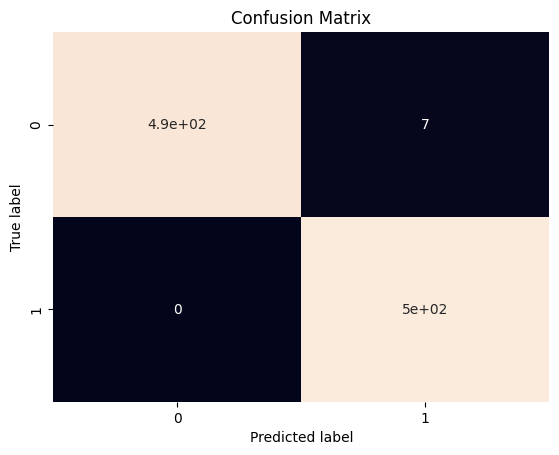

__________vqvae__________
Accuracy 0.992
Precision: 0.998000
Recall: 0.986166
F1 score: 0.992048
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



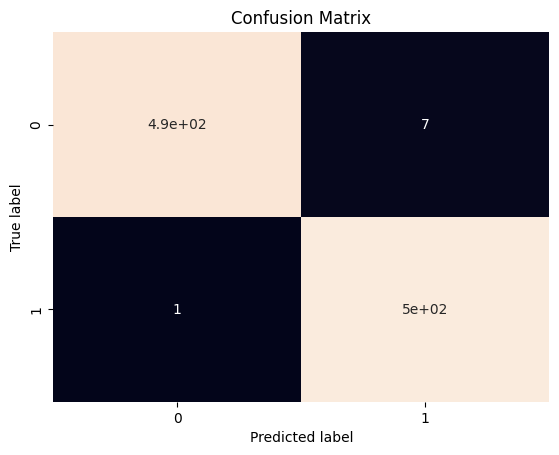



 __________________________________________________ 152_freeze __________________________________________________

__________gen__________
Accuracy 0.762
Precision: 0.694000
Recall: 0.803241
F1 score: 0.744635
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       500
           1       0.80      0.69      0.74       500

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000



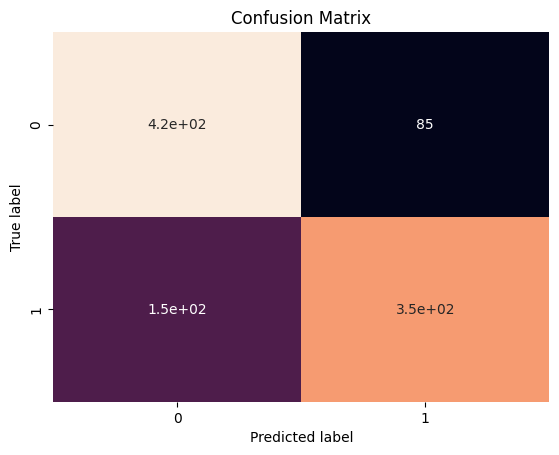

__________ec__________
Accuracy 0.905
Precision: 0.980000
Recall: 0.852174
F1 score: 0.911628
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       500
           1       0.85      0.98      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.90      1000
weighted avg       0.91      0.91      0.90      1000



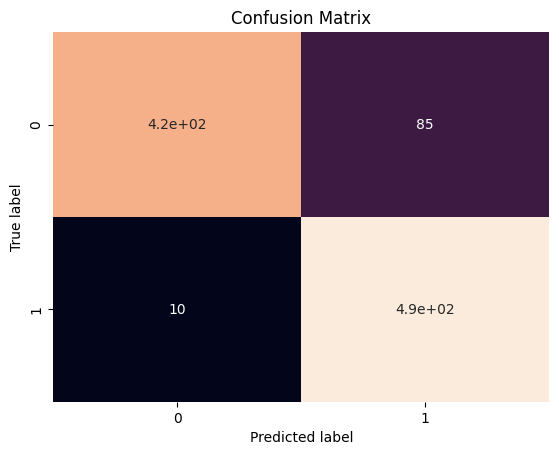

__________vqvae__________
Accuracy 0.887
Precision: 0.944000
Recall: 0.847397
F1 score: 0.893094
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       500
           1       0.85      0.94      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



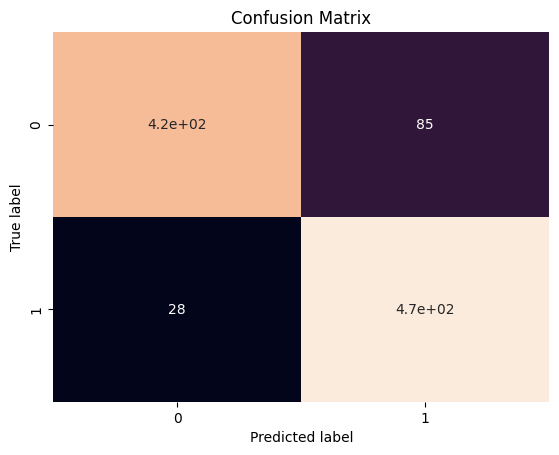



 __________________________________________________ 101_freeze __________________________________________________

__________gen__________
Accuracy 0.554
Precision: 0.620000
Recall: 0.547703
F1 score: 0.581614
              precision    recall  f1-score   support

           0       0.56      0.49      0.52       500
           1       0.55      0.62      0.58       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000



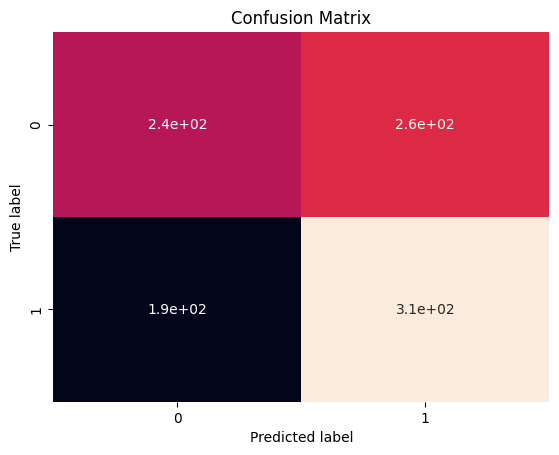

__________ec__________
Accuracy 0.66
Precision: 0.832000
Recall: 0.619048
F1 score: 0.709898
              precision    recall  f1-score   support

           0       0.74      0.49      0.59       500
           1       0.62      0.83      0.71       500

    accuracy                           0.66      1000
   macro avg       0.68      0.66      0.65      1000
weighted avg       0.68      0.66      0.65      1000



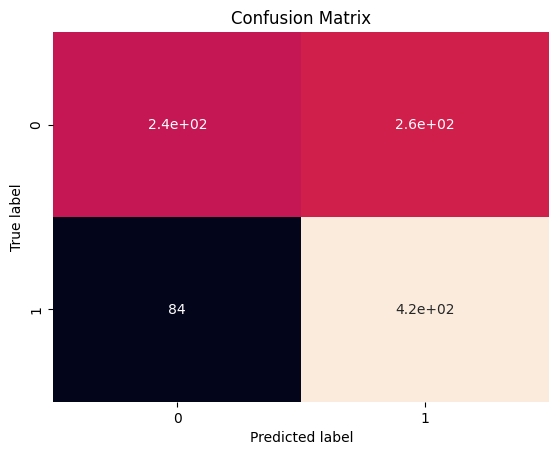

__________vqvae__________
Accuracy 0.522
Precision: 0.556000
Recall: 0.520599
F1 score: 0.537718
              precision    recall  f1-score   support

           0       0.52      0.49      0.51       500
           1       0.52      0.56      0.54       500

    accuracy                           0.52      1000
   macro avg       0.52      0.52      0.52      1000
weighted avg       0.52      0.52      0.52      1000



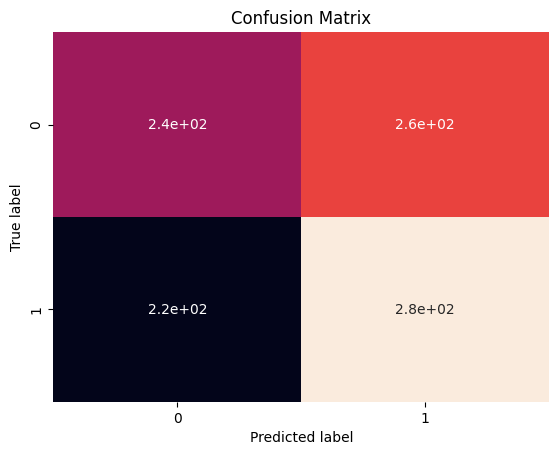



 __________________________________________________ 50_freeze __________________________________________________

__________gen__________
Accuracy 0.574
Precision: 0.534000
Recall: 0.580435
F1 score: 0.556250
              precision    recall  f1-score   support

           0       0.57      0.61      0.59       500
           1       0.58      0.53      0.56       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000



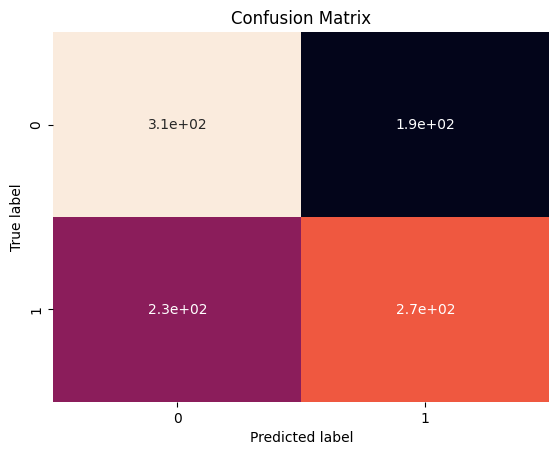

__________ec__________
Accuracy 0.717
Precision: 0.820000
Recall: 0.679934
F1 score: 0.743427
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       500
           1       0.68      0.82      0.74       500

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.71      1000
weighted avg       0.73      0.72      0.71      1000



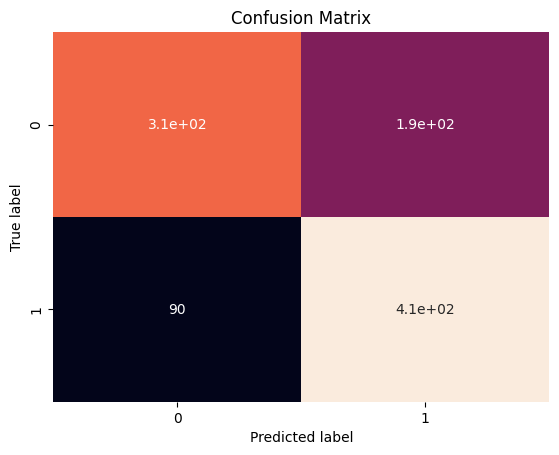

__________vqvae__________
Accuracy 0.566
Precision: 0.518000
Recall: 0.573009
F1 score: 0.544118
              precision    recall  f1-score   support

           0       0.56      0.61      0.59       500
           1       0.57      0.52      0.54       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.56      1000
weighted avg       0.57      0.57      0.56      1000



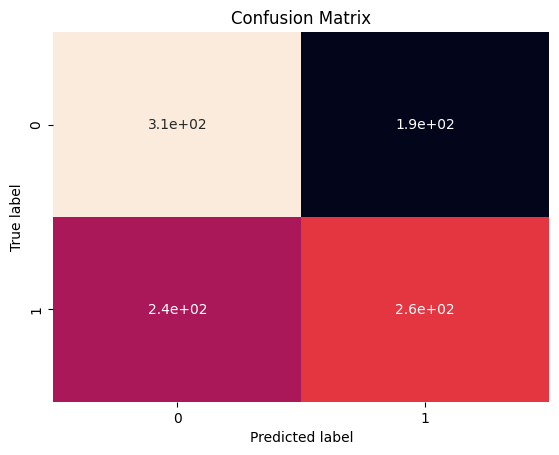

In [24]:
for model_name in model_softmax.keys():
  print("\n\n","_"*50, model_name, "_"*50, end = "\n\n")

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 64)
    y_result = model_svm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    print(classification_report(labels, y_result))

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()